# 2 MNIST classification

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds

## 2.1 Loading the MNIST dataset

In [20]:
(train_ds,val_ds), ds_info = tfds.load('mnist', split =['train', 'test'], as_supervised = True , with_info = True)

In [21]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/Users/jonah/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


2023-11-21 20:14:19.154406: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


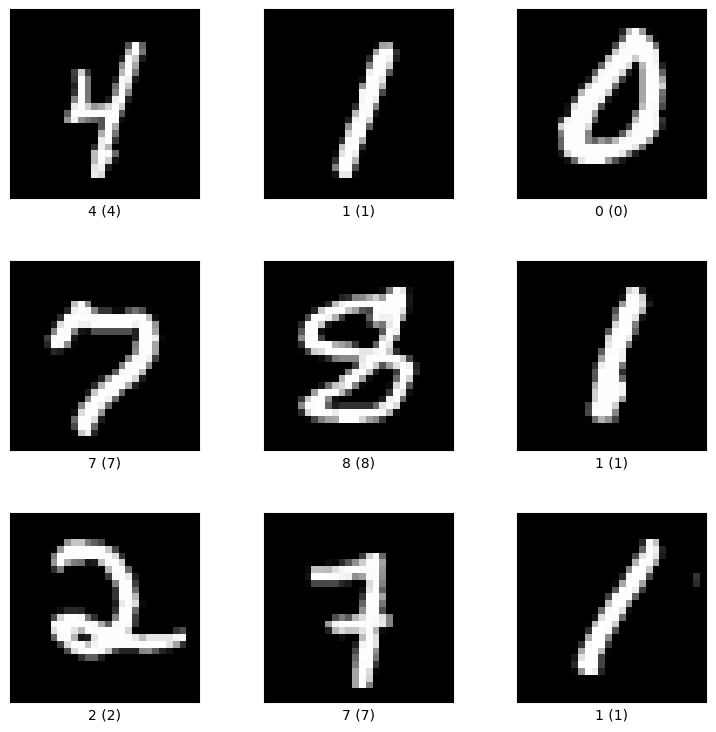

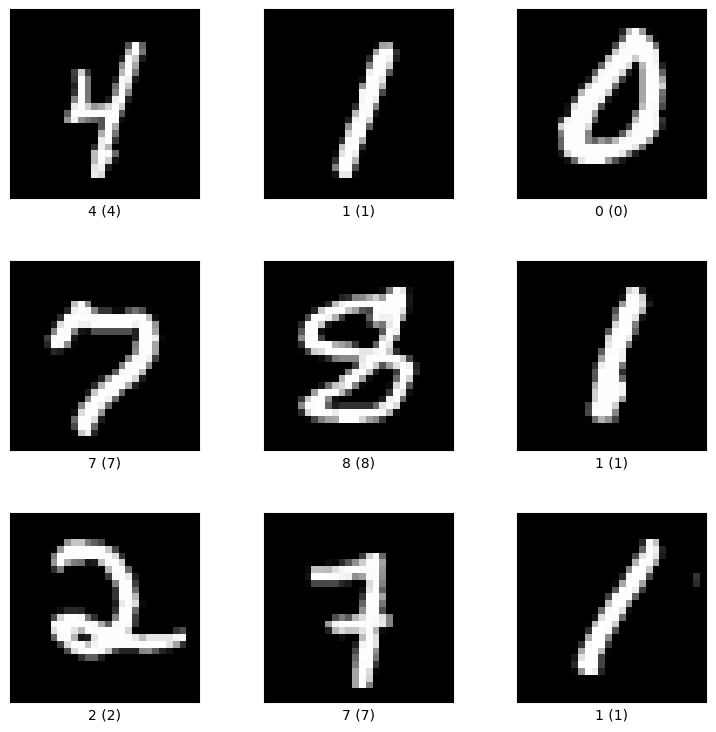

In [22]:
tfds.show_examples(train_ds, ds_info)

### Questions

- How many training/test images are there?
    - There are 60000 training images and 10000 test images.
- What’s the image shape?
    - The shape of each image is (28,28,1).
- What range are pixel values in?
    - The pixels are in uint8 format, meaning they have values in range (0,255)

## 2.2 Setting up the data pipeline

In [23]:
def data_pipeline(ds):
    # flatten image
    ds = ds.map(lambda image, label: (tf.reshape(image, (-1,)), label))
    # cast values to float values between -1 and 1 (normalization)
    ds = ds.map(lambda image, label: ((tf.cast(image, tf.float32)/128)-1, label))
    # one hot encode labels
    ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
    return ds

In [24]:
def batched_prefetch(ds, buffersize=2000, batchsize=200, prefetch=4):
    ds = ds.shuffle(buffersize).batch(batchsize)
    ds = ds.prefetch(prefetch)
    return ds

In [25]:
train_ds = data_pipeline(train_ds)
val_ds = data_pipeline(val_ds)
train_ds = batched_prefetch(ds=train_ds)
val_ds = batched_prefetch(ds=val_ds)

## 2.3 Building a deep neural network with TensorFlow

In [26]:
class MLP_Model(tf.keras.Model):
    def __init__(self, layer_sizes, output_size=10):
        super().__init__()
        self.layers_list = []
        # layer_sizes e.g. [256,256]
        for layer_size in layer_sizes:
            new_layer = tf.keras.layers.Dense(units=layer_size, activation="sigmoid")
            self.layers_list.append(new_layer)
        self.output_layer = tf.keras.layers.Dense(units=output_size, activation="softmax")
        
    def call(self, x):
        for layer in self.layers_list:
            x = layer(x)
        y = self.output_layer(x)
        return y

## 2.4 Training the network

In [27]:
import numpy as np

In [28]:
def training(model, train_ds, val_ds, epochs=10, loss_function=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.legacy.SGD(), train_accuracy=tf.keras.metrics.SparseCategoricalAccuracy(), val_accuracy=tf.keras.metrics.SparseCategoricalAccuracy()):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        train_loss_batches = []
        val_loss_batches = []
        train_accuracy_batches = []
        val_accuracy_batches = []
        
        for step, (x_batch_train, target_batch_train) in enumerate(train_ds):
            with tf.GradientTape() as tape: # context manager ('with' opens context)
                logits = model(x_batch_train, training=True)
                train_loss = loss_function(y_true=target_batch_train, y_pred=logits)
            grad = tape.gradient(train_loss, model.variables)
            optimizer.apply_gradients(zip(grad, model.variables))
            
            train_accuracy.update_state(tf.argmax(target_batch_train, axis=1), logits)
            
            train_loss_batches.append(train_loss.numpy())
            train_accuracy_batches.append(float(train_accuracy.result()))
            
            # Log every 200 batches.
            if step % 200 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, float(train_loss))
                )
                print(
                    "Training accuracy (for one batch) at step %d: %.4f"
                    % (step, float(train_accuracy.result()))
                )
                print("Seen so far: %s samples" % ((step + 1) * 200))

        train_losses.append(np.mean(train_loss_batches))
        train_accuracies.append(np.mean(train_accuracy_batches))
         # Reset training metrics at the end of each epoch
        train_accuracy.reset_states()

        # Run a validation loop at the end of each epoch.
        for x_batch_val, target_batch_val in val_ds:
            val_logits = model(x_batch_val, training=False)
            val_accuracy.update_state(tf.argmax(target_batch_val, axis=1), val_logits)
            val_loss = loss_function(y_true=target_batch_val, y_pred=val_logits)
            val_loss_batches.append(val_loss.numpy())
            val_accuracy_batches.append(float(val_accuracy.result()))
        val_losses.append(np.mean(val_loss_batches))
        val_accuracies.append(np.mean(val_accuracy_batches))
        print("Validation acc: %.4f" % (float(val_accuracy.result()),))
        val_accuracy.reset_states()
    return train_losses, val_losses, train_accuracies, val_accuracies


In [29]:
train_losses, val_losses, train_accuracies, val_accuracies = training(model=MLP_Model(layer_sizes=[256,256,256]),
                                                                        train_ds=train_ds,
                                                                        val_ds=val_ds,
                                                                        epochs=6,
                                                                        loss_function=tf.keras.losses.CategoricalCrossentropy(),
                                                                        optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9))


Start of epoch 0
Training loss (for one batch) at step 0: 2.6256
Training accuracy (for one batch) at step 0: 0.1100
Seen so far: 200 samples
Training loss (for one batch) at step 200: 2.2714
Training accuracy (for one batch) at step 200: 0.1345
Seen so far: 40200 samples
Validation acc: 0.3412

Start of epoch 1
Training loss (for one batch) at step 0: 2.1567
Training accuracy (for one batch) at step 0: 0.3250
Seen so far: 200 samples
Training loss (for one batch) at step 200: 1.5428
Training accuracy (for one batch) at step 200: 0.4732
Seen so far: 40200 samples
Validation acc: 0.6732

Start of epoch 2
Training loss (for one batch) at step 0: 1.1396
Training accuracy (for one batch) at step 0: 0.6450
Seen so far: 200 samples
Training loss (for one batch) at step 200: 0.7909
Training accuracy (for one batch) at step 200: 0.7346
Seen so far: 40200 samples
Validation acc: 0.8091

Start of epoch 3
Training loss (for one batch) at step 0: 0.6313
Training accuracy (for one batch) at step 0

## 2.5 Visualization

In [30]:
import matplotlib.pyplot as plt

In [31]:
def visualization (train_losses, train_accuracies, val_losses, val_accuracies):
    """ Visualizes accuracy and loss for training and test data using
        the mean of each epoch.
        
        Loss is displayed in a regular line, accuracy in a dotted line.
        Training data is displayed in blue, test data in red.
    
    Parameters
    ----------
    train_losses : numpy . ndarray
    training losses
    train_accuracies : numpy . ndarray
    training accuracies
    val_losses : numpy . ndarray
    val losses
    val_accuracies : numpy . ndarray
    val accuracies
    """
    #plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(val_losses, "r-")
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(val_accuracies, "r:")
    plt.xlabel("Training steps")
    plt.ylabel("Loss / Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "validation loss", "train accuracy", "validation accuracy"))
    plt.show()

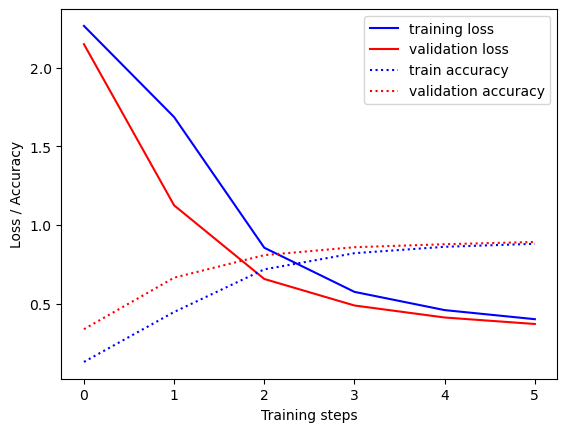

In [32]:
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

# 3 Adjusting the hyperparameters of your model

## Deviation Learning rate

In [33]:
train_losses, val_losses, train_accuracies, val_accuracies = training(model=MLP_Model(layer_sizes=[256,256,256]),
                                                                        train_ds=train_ds,
                                                                        val_ds=val_ds,
                                                                        epochs=6,
                                                                        loss_function=tf.keras.losses.CategoricalCrossentropy(),
                                                                        optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.9))


Start of epoch 0
Training loss (for one batch) at step 0: 2.6716
Training accuracy (for one batch) at step 0: 0.1050
Seen so far: 200 samples
Training loss (for one batch) at step 200: 0.3528
Training accuracy (for one batch) at step 200: 0.5474
Seen so far: 40200 samples
Validation acc: 0.8952

Start of epoch 1
Training loss (for one batch) at step 0: 0.3576
Training accuracy (for one batch) at step 0: 0.8800
Seen so far: 200 samples
Training loss (for one batch) at step 200: 0.2610
Training accuracy (for one batch) at step 200: 0.9048
Seen so far: 40200 samples
Validation acc: 0.9382

Start of epoch 2
Training loss (for one batch) at step 0: 0.1340
Training accuracy (for one batch) at step 0: 0.9350
Seen so far: 200 samples
Training loss (for one batch) at step 200: 0.1970
Training accuracy (for one batch) at step 200: 0.9379
Seen so far: 40200 samples
Validation acc: 0.9443

Start of epoch 3
Training loss (for one batch) at step 0: 0.1235
Training accuracy (for one batch) at step 0

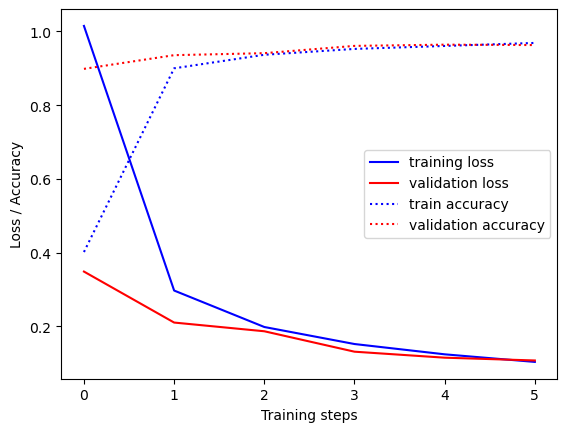

In [34]:
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

#### Interpretation:

The provided output show the training progress and validation accuracy of a neural network with a learning rates: 0.1. The learning rate in the standard case above was 0.01.
First, a higher learning rate leads to the weights being adjusted more strongly in the backpropagation process and the neural network converges faster.
This is exactly what can be observed in this case. However, a learning rate that is set too high harbors the risk of overshooting and instability due to the repeated strong adjustment of the weights and biases.

**Learning Rate 0.01:**

Epoch 0: The model starts with a training accuracy of around 10%. The training and validation accuracies improve gradually over epochs. The validation accuracy reaches 33.96% at the end of the first epoch and continues to improve with subsequent epochs.
Epoch 5: The final validation accuracy is 89.14%.

**Learning Rate 0.1:**

Epoch 0: With a higher learning rate, the model starts with a training accuracy of 8%. Despite the initially lower accuracy, the model makes larger updates to its weights, resulting in faster convergence. The validation accuracy is 89.21% at the end of the first epoch, already comparable to the 0.01 learning rate case.
Epoch 5: The final validation accuracy is 96.71%.

In summary, a learning rate of 0.1 appears to be more effective in this scenario, leading to faster convergence and a higher final accuracy. However, it's crucial to carefully monitor and potentially adjust the learning rate during training to avoid instability issues.

**!!!The values given here are values from a previous training session and may of course vary slightly with each subsequent run.**

## Deviation Layer Size

In [39]:
train_losses, val_losses, train_accuracies, val_accuracies = training(model=MLP_Model(layer_sizes=[50,50,50]),
                                                                        train_ds=train_ds,
                                                                        val_ds=val_ds,
                                                                        epochs=6,
                                                                        loss_function=tf.keras.losses.CategoricalCrossentropy(),
                                                                        optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9))


Start of epoch 0
Training loss (for one batch) at step 0: 2.3312
Training accuracy (for one batch) at step 0: 0.1400
Seen so far: 200 samples
Training loss (for one batch) at step 200: 2.2791
Training accuracy (for one batch) at step 200: 0.1302
Seen so far: 40200 samples
Validation acc: 0.2200

Start of epoch 1
Training loss (for one batch) at step 0: 2.2454
Training accuracy (for one batch) at step 0: 0.2200
Seen so far: 200 samples
Training loss (for one batch) at step 200: 2.0718
Training accuracy (for one batch) at step 200: 0.3355
Seen so far: 40200 samples
Validation acc: 0.4619

Start of epoch 2
Training loss (for one batch) at step 0: 1.8115
Training accuracy (for one batch) at step 0: 0.5100
Seen so far: 200 samples
Training loss (for one batch) at step 200: 1.4089
Training accuracy (for one batch) at step 200: 0.5157
Seen so far: 40200 samples
Validation acc: 0.6306

Start of epoch 3
Training loss (for one batch) at step 0: 1.1759
Training accuracy (for one batch) at step 0

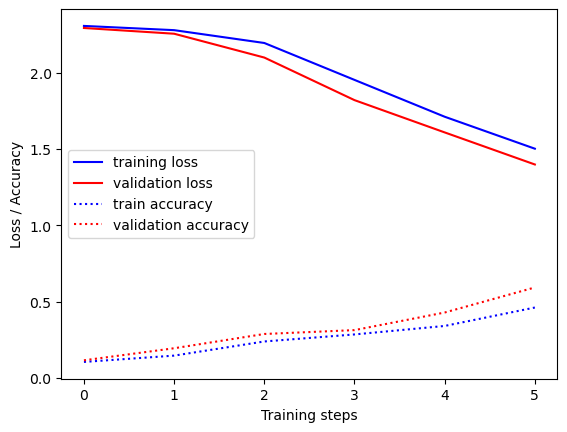

In [36]:
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

#### Interpretation

**Three Layers with Each 50 Units:**

Epoch 0: The model starts with low training accuracy and high training loss. Validation accuracy is also relatively low, indicating a model that has not yet learned meaningful representations.
Epoch 1-2: The model shows improvement with each epoch, as both training and validation accuracies increase, and training loss decreases.
Epoch 3-5: Continued improvement is observed, with increasing accuracies and decreasing loss. The model is learning well, and validation accuracy reaches a respectable level.

**Three Layers with Each 256 Units:**

Epoch 0: Similar to the 50-unit case, the model starts with low training accuracy and high training loss. Validation accuracy is also low.
Epoch 1-2: Significant improvement is seen, and the model quickly surpasses the performance of the 50-unit model. The higher number of units per layer allows for more expressive representations and faster learning.
Epoch 3-5: The model continues to perform well, achieving higher validation accuracy compared to the 50-unit model. The increased capacity appears to benefit the learning process.

Models with more units per layer (256 units) generally outperform those with fewer units (50 units) in terms of both convergence speed and final accuracy.
Higher-capacity models (256 units) have the ability to capture more intricate features in the data, leading to better performance.
However, increasing the number of units also comes with a computational cost. It's essential to find a balance between model complexity and computational resources.

**!!!The values given here are values from a previous training session and may of course vary slightly with each subsequent run.**

## Deviation Number of layers

In [37]:
train_losses, val_losses, train_accuracies, val_accuracies = training(model=MLP_Model(layer_sizes=[256,256,256,256]),
                                                                        train_ds=train_ds,
                                                                        val_ds=val_ds,
                                                                        epochs=6,
                                                                        loss_function=tf.keras.losses.CategoricalCrossentropy(),
                                                                        optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9))


Start of epoch 0
Training loss (for one batch) at step 0: 2.4913
Training accuracy (for one batch) at step 0: 0.1300
Seen so far: 200 samples
Training loss (for one batch) at step 200: 2.3024
Training accuracy (for one batch) at step 200: 0.1046
Seen so far: 40200 samples
Validation acc: 0.1135

Start of epoch 1
Training loss (for one batch) at step 0: 2.2966
Training accuracy (for one batch) at step 0: 0.1250
Seen so far: 200 samples
Training loss (for one batch) at step 200: 2.3095
Training accuracy (for one batch) at step 200: 0.1137
Seen so far: 40200 samples
Validation acc: 0.1135

Start of epoch 2
Training loss (for one batch) at step 0: 2.2861
Training accuracy (for one batch) at step 0: 0.1000
Seen so far: 200 samples
Training loss (for one batch) at step 200: 2.2785
Training accuracy (for one batch) at step 200: 0.1377
Seen so far: 40200 samples
Validation acc: 0.1036

Start of epoch 3
Training loss (for one batch) at step 0: 2.2662
Training accuracy (for one batch) at step 0

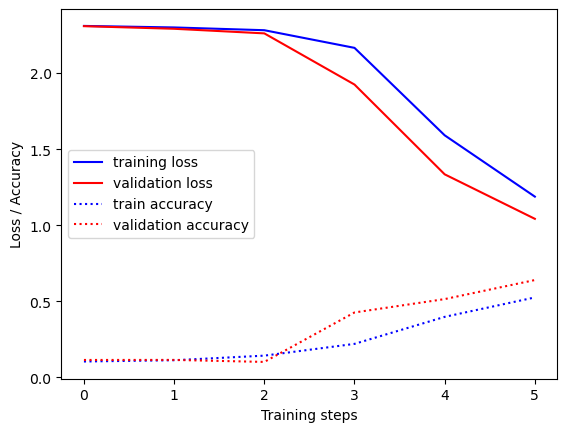

In [38]:
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

#### Interpetation:

The provided results demonstrate the impact of changing the number of hidden layers in a neural network, specifically comparing networks with 3 hidden layers, each consisting of 256 units, to networks with 4 hidden layers, each also consisting of 256 units.

**Three Hidden Layers (each with 256 units):**

*The training loss decreases significantly over epochs, indicating that the network is learning from the data.
Training accuracy increases, reaching 88.12% at the end of epoch 5.
Validation accuracy steadily improves and reaches 89.14% at epoch 5.*

**Four Hidden Layers (each with 256 units):**

*The training loss starts high and doesn't decrease significantly over epochs.
Training accuracy remains relatively low, reaching 62.15% at the end of epoch 5.
Validation accuracy is consistently low, reaching only 74.62% at epoch 5.*


"The network with three hidden layers exhibits better training and validation performance compared to the network with four hidden layers.
Increasing the number of layers doesn't necessarily lead to improved performance. In this case, the deeper network struggles to learn effectively, as indicated by slow convergence and lower accuracy."

**!!!The values given here are values from a previous training session and may of course vary slightly with each subsequent run.**

## Deviation 4

In [42]:
train_losses, val_losses, train_accuracies, val_accuracies = training(model=MLP_Model(layer_sizes=[256,256,256,256]),
                                                                        train_ds=train_ds,
                                                                        val_ds=val_ds,
                                                                        epochs=6,
                                                                        loss_function=tf.keras.losses.CategoricalCrossentropy(),
                                                                        optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.99))


Start of epoch 0
Training loss (for one batch) at step 0: 2.6370
Training accuracy (for one batch) at step 0: 0.1250
Seen so far: 200 samples
Training loss (for one batch) at step 200: 2.3030
Training accuracy (for one batch) at step 200: 0.1081
Seen so far: 40200 samples
Validation acc: 0.1032

Start of epoch 1
Training loss (for one batch) at step 0: 2.2985
Training accuracy (for one batch) at step 0: 0.1300
Seen so far: 200 samples
Training loss (for one batch) at step 200: 2.2683
Training accuracy (for one batch) at step 200: 0.1163
Seen so far: 40200 samples
Validation acc: 0.2734

Start of epoch 2
Training loss (for one batch) at step 0: 1.8249
Training accuracy (for one batch) at step 0: 0.2850
Seen so far: 200 samples
Training loss (for one batch) at step 200: 1.1962
Training accuracy (for one batch) at step 200: 0.4056
Seen so far: 40200 samples
Validation acc: 0.7080

Start of epoch 3
Training loss (for one batch) at step 0: 0.9138
Training accuracy (for one batch) at step 0

#### Interpretation:

**Momentum = 0.9:**

*Epoch 0-1: The model begins with low accuracy, but there is steady improvement in both training and validation accuracy. The momentum of 0.9 aids convergence by allowing the model to overcome local minima.
Epoch 2-5: The model continues to improve, reaching a validation accuracy of 89.31%. The momentum contributes to stable convergence.*

**Momentum = 0.99:**

*Epoch 0-1: The model starts with low accuracy and experiences slow progress in the first epoch. The high momentum of 0.99 might be causing the model to overshoot the optimal weights.
Epoch 2-5: While there is improvement, the model struggles to reach high accuracy. The high momentum may contribute to oscillations and hinder convergence.*


The choice of momentum interacts with the learning rate, and the results suggest that a momentum value of 0.9 tends to provide more stable and effective convergence compared to 0.99.

**!!!The values given here are values from a previous training session and may of course vary slightly with each subsequent run.**